# Energy Price Prediction with ARIMA & SARIMA

In [98]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime


from scipy import stats
import statsmodels.api as sm
from itertools import product

import plotly.graph_objects as go
from ta.trend import MACD
from ta.momentum import RSIIndicator
from ta.volatility import BollingerBands
from statsmodels.tsa.stattools import adfuller
from numpy import log
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

sns.set(rc={"axes.facecolor":"Beige" , "axes.grid" : False})

In [13]:
df = pd.read_csv(r"D:\UNH Materials\Projects\Energy Price Predictions\European Energy Market\data\EU_energy_data.csv")
df.head()

,Unnamed: 0,fecha,hora,sistema,bandera,precio,tipo_moneda,origen_dato,fecha_actualizacion
0,0,2010-07-21,1,HU,1,39.287,1,6,2021-10-01 12:39:53
1,1,2010-07-21,2,HU,1,35.925,1,6,2021-10-01 12:39:53
2,2,2010-07-21,3,HU,1,33.223,1,6,2021-10-01 12:39:53
3,3,2010-07-21,4,HU,1,30.842,1,6,2021-10-01 12:39:53
4,4,2010-07-21,5,HU,1,33.395,1,6,2021-10-01 12:39:53


In [21]:
df.shape

(1831555, 7)

In [14]:
# Rename Columns
df = df.rename(columns = {'fecha' : 'Date',
                          'hora' : 'Hour' , 
                          'sistema' : 'EU_countries',
                          'bandera' : 'Renewable/Non_Renewable',
                          'precio' : 'Cost(€/MWh)',
                          'tipo_moneda' : 'CurrencyType',
                          'origen_dato' : 'DataSource', 
                          'fecha_actualizacion' : 'Updated_Date'}
                )                                                
df = df.drop('Unnamed: 0',axis=1)

In [15]:
df.head()

,Date,Hour,EU_countries,Renewable/Non_Renewable,Cost(€/MWh),CurrencyType,DataSource,Updated_Date
0,2010-07-21,1,HU,1,39.287,1,6,2021-10-01 12:39:53
1,2010-07-21,2,HU,1,35.925,1,6,2021-10-01 12:39:53
2,2010-07-21,3,HU,1,33.223,1,6,2021-10-01 12:39:53
3,2010-07-21,4,HU,1,30.842,1,6,2021-10-01 12:39:53
4,2010-07-21,5,HU,1,33.395,1,6,2021-10-01 12:39:53


In [16]:
# Merge Date and Hour columns
df['Hour'] = df['Hour'].astype(str).str.zfill(2)
try:
    df['Hour'] = pd.to_numeric(df['Hour'])
except:
    # Handle conversion errors (e.g., non-numeric characters)
    print("Error converting 'Hour' column to numeric")

# Function to convert the range
def convert_range(value):
    # Handle edge cases (leading zero and exceeding 24)
    if value == '01':
        return 0
    elif value > 24:
        raise ValueError("Value exceeds 24")
    else:
        # Remove leading zero (assuming strings) or subtract 1 (assuming integers)
        return int(value) - 1 if isinstance(value, int) else int(value[1:])

# Function to replace values with leading zeros (handles all cases)
def replace_with_leading_zero(value):
    if 0 <= value <= 23:
        return f"{value:02d}"  # Use f-string for consistent formatting
    else:
        raise ValueError(f"Value {value} is outside the range 0-12")

In [17]:
# Apply the function
df['Hour'] = df['Hour'].apply(convert_range)
df['Hour'] = df['Hour'].apply(replace_with_leading_zero)
df['Hour'] = df['Hour'].astype(str)  # Ensure Hour is string type
df['Hour'] = df['Hour'] + ':00:00'

df["Period"] = df[["Date","Hour"]].apply(" ".join, axis=1)

# Filter useful columns
df = df [['Period','EU_countries', 'Renewable/Non_Renewable',
       'Cost(€/MWh)', 'CurrencyType', 'DataSource', 'Updated_Date']]

df['Period'] = pd.to_datetime(df['Period'],format ="%Y-%m-%d %H:%M:%S" )
df.head()

,Period,EU_countries,Renewable/Non_Renewable,Cost(€/MWh),CurrencyType,DataSource,Updated_Date
0,2010-07-21 00:00:00,HU,1,39.287,1,6,2021-10-01 12:39:53
1,2010-07-21 01:00:00,HU,1,35.925,1,6,2021-10-01 12:39:53
2,2010-07-21 02:00:00,HU,1,33.223,1,6,2021-10-01 12:39:53
3,2010-07-21 03:00:00,HU,1,30.842,1,6,2021-10-01 12:39:53
4,2010-07-21 04:00:00,HU,1,33.395,1,6,2021-10-01 12:39:53


In [24]:
# Let's Analyse a Specific Country = France
df_France = df[df['EU_countries']== "FR"]

# Remove the unnecessary feature
df_France = df_France.drop(['EU_countries','CurrencyType','DataSource','Updated_Date','Renewable/Non_Renewable'],axis=1)
df_France.head().style.set_properties(subset=['Period'], **{'background-color': 'yellow'})

,Period,Cost(€/MWh)
179166,2014-01-01 00:00:00,15.150000
179187,2014-01-01 01:00:00,12.960000
179208,2014-01-01 02:00:00,12.090000
179229,2014-01-01 03:00:00,11.700000
179250,2014-01-01 04:00:00,11.660000


In [25]:
# Creating a copy to keep original Dataset intact
France_df = df_France.copy('Deep')

In [26]:
df_France = df_France.set_index('Period')
df_France.sort_index(inplace=True)
df_France.head()

,Cost(€/MWh)
Period,
2014-01-01 00:00:00,15.15
2014-01-01 01:00:00,12.96
2014-01-01 02:00:00,12.09
2014-01-01 03:00:00,11.70
2014-01-01 04:00:00,11.66


# Exploratory Data Analysis and Visualization

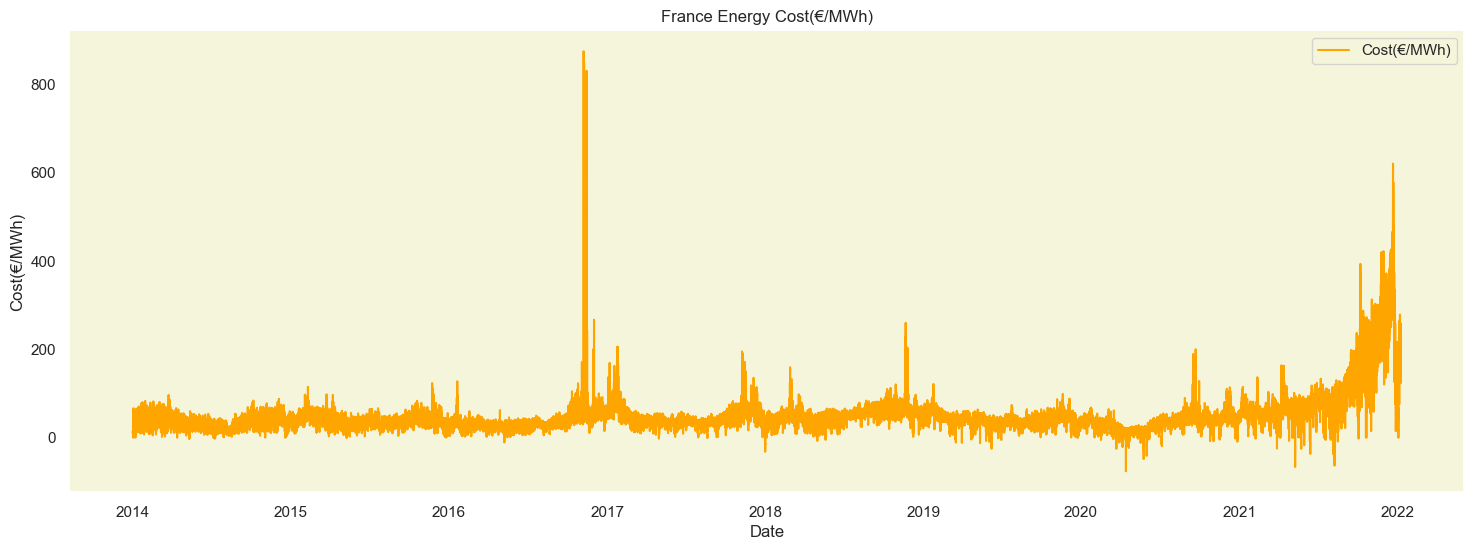

In [61]:
# Energy Cost over the period
plt.figure(figsize = (18,6))
plt.plot(df_France.index,df_France['Cost(€/MWh)'],label= 'Cost(€/MWh)',color = 'orange')
plt.title('France Energy Cost(€/MWh)')
plt.xlabel('Date')
plt.ylabel('Cost(€/MWh)')
plt.grid(False)
plt.legend()
plt.show()

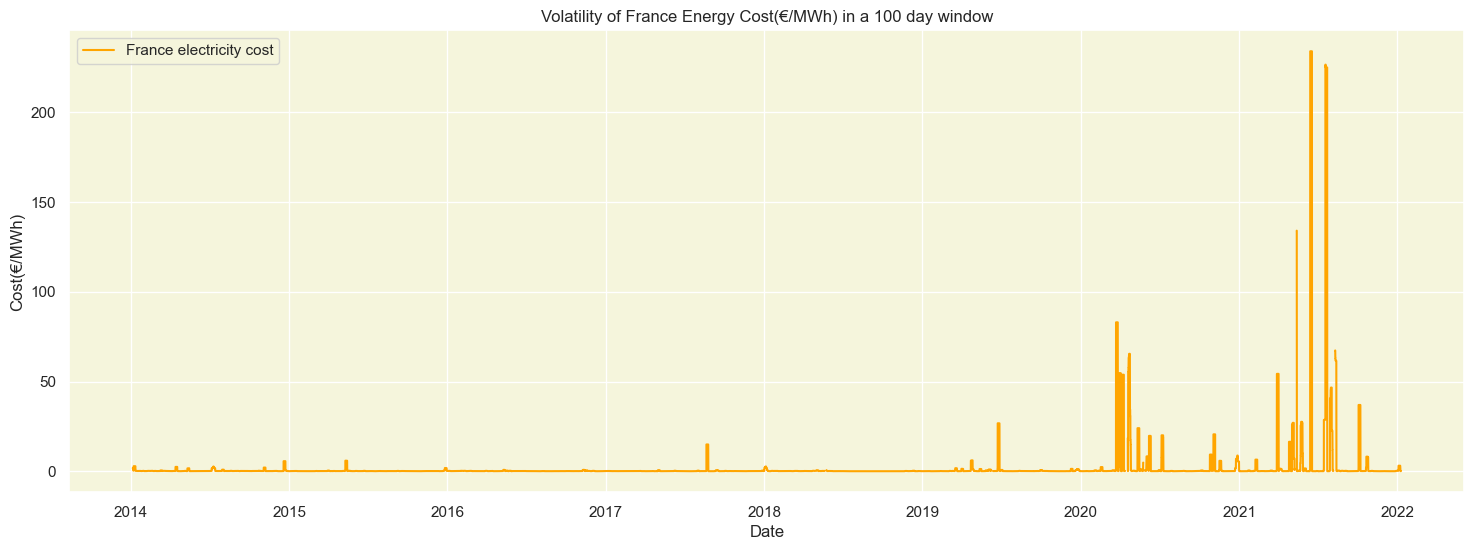

In [68]:
# Percent Change over a 100 time period window
df_France['Change'] = df_France['Cost(€/MWh)'].pct_change()
window_size = 100
df_100 = df_France['Change'].rolling(window = window_size).std()

#plotting
plt.figure(figsize = (18,6))
plt.plot(df_France.index , df_100 , label = 'France electricity cost' , color = 'orange')
plt.title('Volatility of France Energy Cost(€/MWh) in a 100 day window')
plt.xlabel('Date')
plt.ylabel('Cost(€/MWh)')
plt.legend()
plt.grid(True)
plt.show()

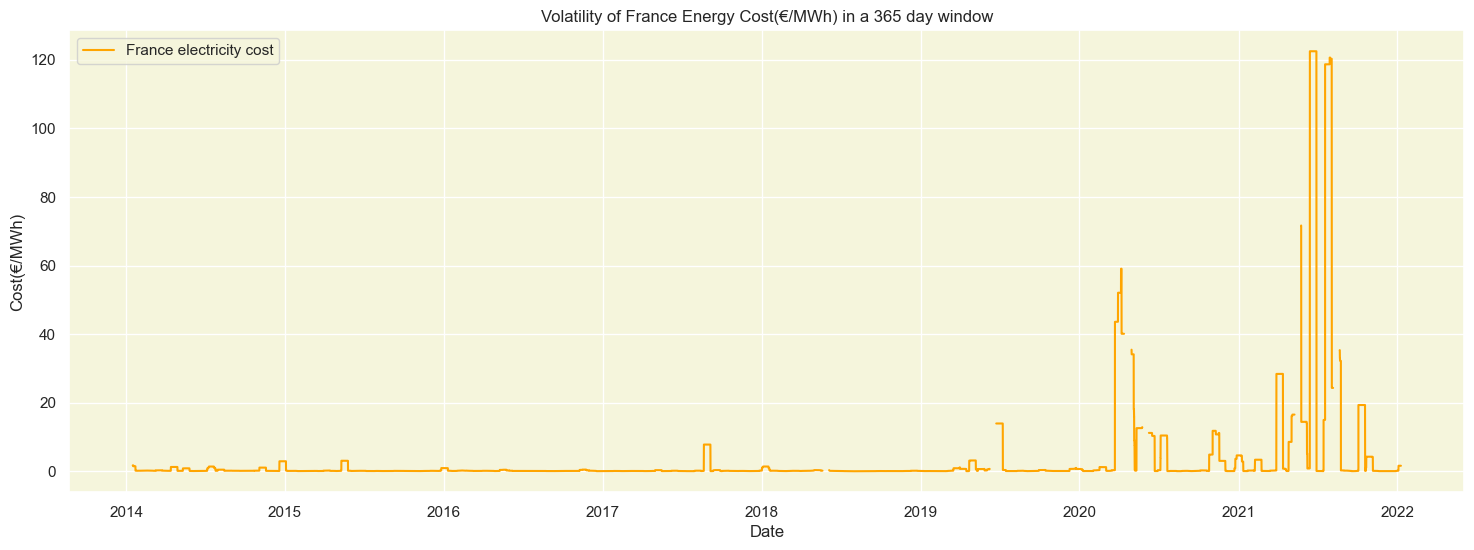

In [69]:
# Percent Change over a 365 day (Year) time period window
df_France['Change'] = df_France['Cost(€/MWh)'].pct_change()
window_size = 365
df_365 = df_France['Change'].rolling(window = window_size).std()

#plotting
plt.figure(figsize = (18,6))
plt.plot(df_France.index , df_365 , label = 'France electricity cost' , color = 'orange')
plt.title('Volatility of France Energy Cost(€/MWh) in a 365 day window')
plt.xlabel('Date')
plt.ylabel('Cost(€/MWh)')
plt.legend()
plt.grid(True)
plt.show()

In [70]:
# Moving Average and Exponential Moving Average Over a period of 30 days
df_France['MA'] = df_France['Cost(€/MWh)'].rolling(window = 30).mean()
df_France['EMA'] = df_France['Cost(€/MWh)'].ewm(span = 30 , adjust = False).mean()

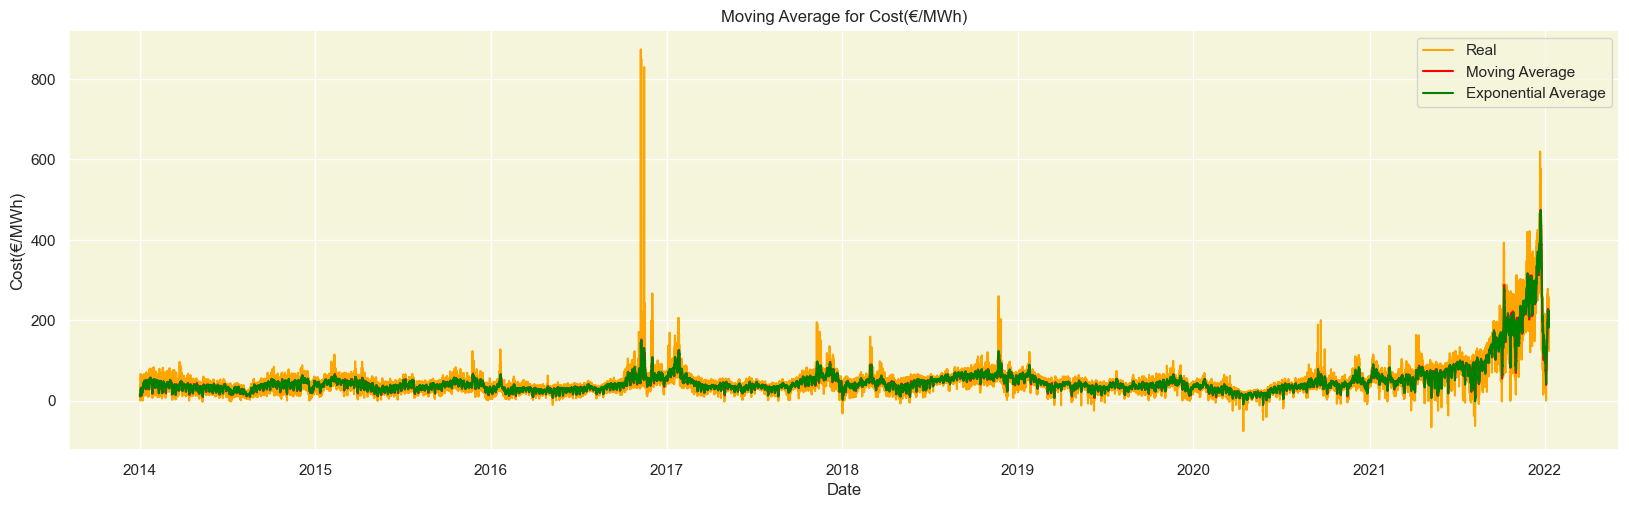

In [80]:
plt.figure(figsize = (20,12))

plt.subplot(2,1,1)
plt.plot(df_France.index,df_France['Cost(€/MWh)'], label = 'Real', color='orange')
plt.plot(df_France.index,df_France['MA'] , label = 'Moving Average' , color = 'red')
plt.plot(df_France.index,df_France['EMA'] , label = 'Exponential Average' , color = 'green')
plt.title('Moving Average for Cost(€/MWh)')
plt.xlabel('Date')
plt.ylabel('Cost(€/MWh)')
plt.legend()
plt.grid()

In [81]:
# Now we will use France_df which we created earlier
France_df = France_df.set_index('Period')
France_df.head()

,Cost(€/MWh)
Period,
2014-01-01 00:00:00,15.15
2014-01-01 01:00:00,12.96
2014-01-01 02:00:00,12.09
2014-01-01 03:00:00,11.70
2014-01-01 04:00:00,11.66


# Augmented Dickey-Fuller (ADF) test to check Stationarity in Time Series data

In [84]:
result = adfuller(France_df['Cost(€/MWh)'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print("\n")
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')  

ADF Statistic: -7.237777
p-value: 0.000000


Critial Values:
   1%, -3.430443076272825
Critial Values:
   5%, -2.8615811380624825
Critial Values:
   10%, -2.5667918963845726


The p-value is less than 0.05, hence we can reject the null hypothesis and take that the series is stationary.

# Auto Correlation Plot

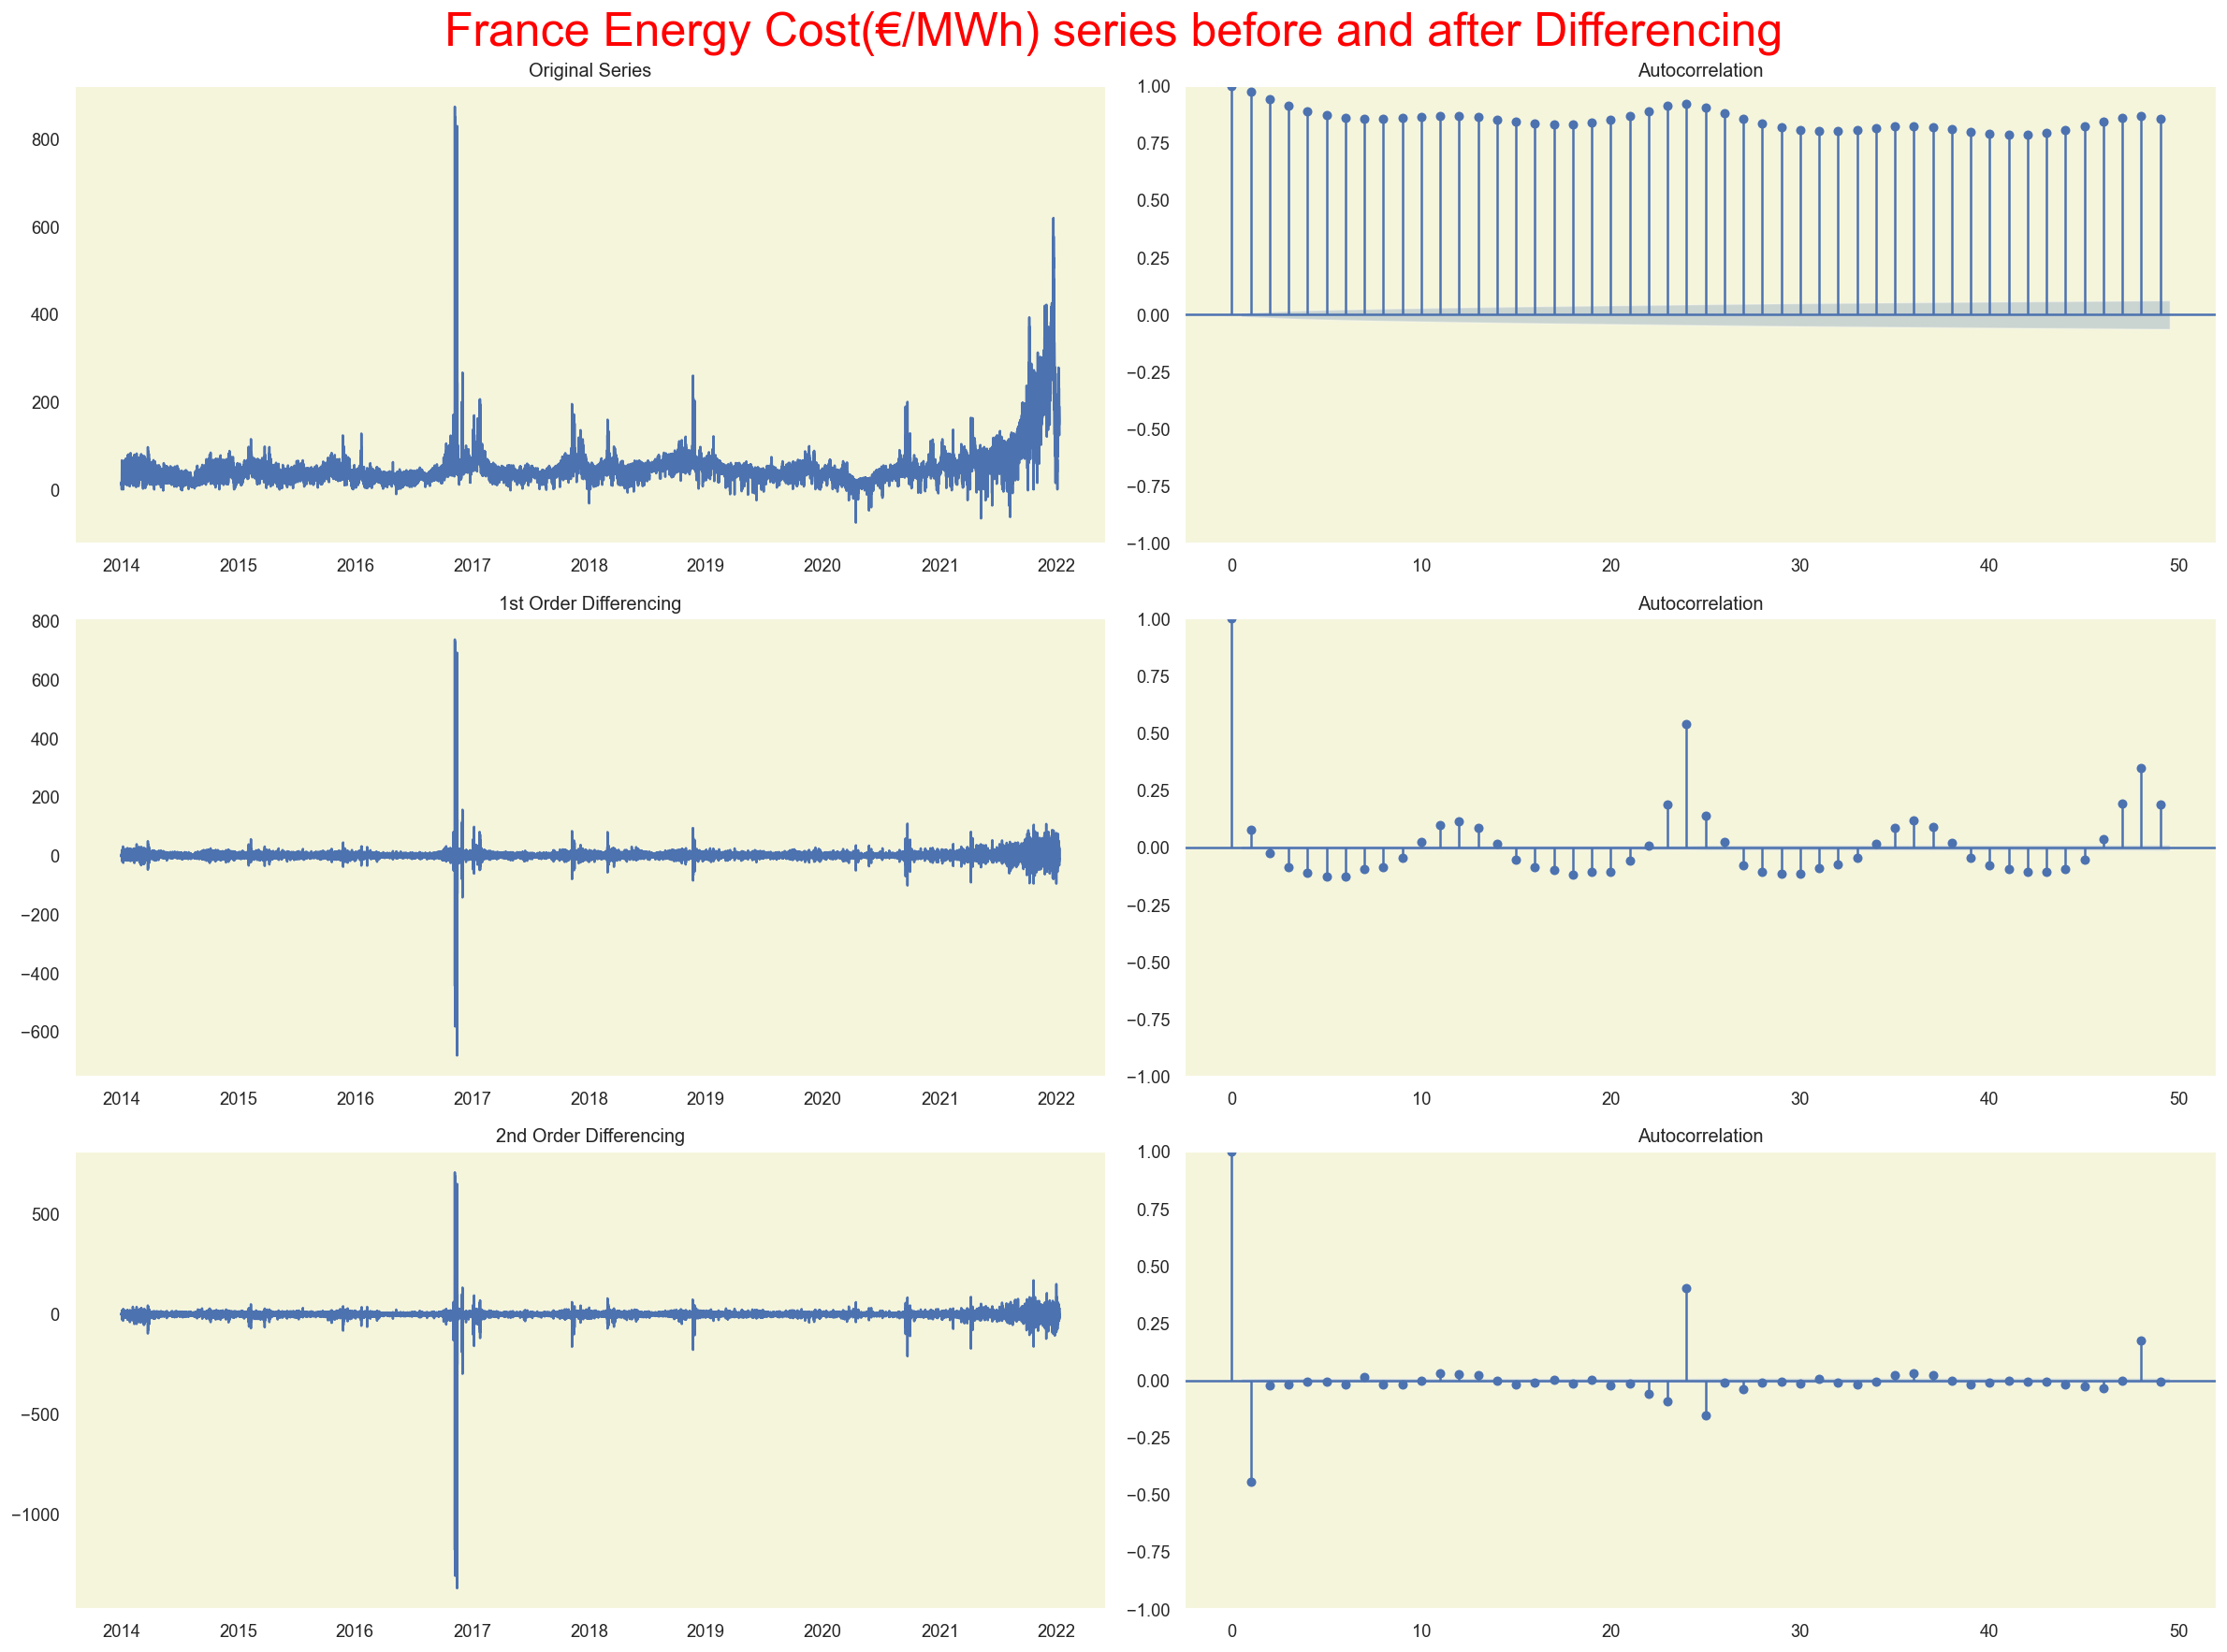

In [91]:
plt.rcParams.update({'figure.figsize':(20,15), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 2)
axes[0, 0].plot(France_df['Cost(€/MWh)'])
axes[0, 0].set_title('Original Series')

# Plotting the ACF
plot_acf(France_df['Cost(€/MWh)'], ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(France_df['Cost(€/MWh)'].diff())
axes[1, 0].set_title('1st Order Differencing')
plot_acf(France_df['Cost(€/MWh)'].diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(France_df['Cost(€/MWh)'].diff().diff())
axes[2, 0].set_title('2nd Order Differencing')
plot_acf(France_df['Cost(€/MWh)'].diff().diff().dropna(), ax=axes[2, 1])

plt.suptitle('France Energy Cost(€/MWh) series before and after Differencing', size = 30,color= 'Red')
plt.tight_layout()

# fig.subplots_adjust(hspace=0.4)

plt.show()

# ARIMA Model

### ARIMA: A Time Machine for Predictions
ARIMA, standing for Autoregressive Integrated Moving Average, is a statistical model that empowers you to forecast future values based on past observations in a time series dataset. It's a popular choice for analyzing and predicting trends in various fields, from finance (stock prices) to weather forecasting (temperature variations).

### The Building Blocks of ARIMA:
ARIMA breaks down the time series into three key components:

1. Autoregressive (AR): This captures the influence of past values on the current value. Imagine predicting tomorrow's stock price; ARIMA considers the closing prices from the past few days (up to a specified order 'p') to make a prediction.

2. Integrated (I): Sometimes, data exhibits non-stationarity, meaning its characteristics (mean, variance) change over time. Differencing, a technique that removes the trend by subtracting the previous value from the current value, is applied (up to order 'd') to achieve stationarity.

3. Moving Average (MA): This component considers the impact of past forecast errors (up to order 'q') on the current prediction. Essentially, it incorporates the idea that errors from past predictions might influence future errors, helping to refine the forecast.

### Understanding the Notation:
ARIMA models are represented using the notation ARIMA(p, d, q), where:

- p signifies the number of autoregressive terms (past values considered).
- d indicates the degree of differencing needed to achieve stationarity.
- q represents the number of moving average terms (past forecast errors considered).

### Example: Predicting Sales Figures
Suppose you're a business analyst tasked with forecasting monthly sales. You might use an ARIMA model to analyze historical sales data. Here's a breakdown of a possible scenario:

- ARIMA(2, 1, 1): This model considers the influence of the past two months' sales figures (p=2) and incorporates differencing once (d=1) to remove any trends. Additionally, it takes into account the error from the previous month's forecast (q=1) to refine the current prediction.

### Strengths of ARIMA:
1. Effective for Stationary Data: ARIMA excels at analyzing and forecasting time series data that exhibits stationarity.
2. Relatively Straightforward Implementation: Compared to more complex models, ARIMA offers a good balance between accuracy and interpretability.
3. Wide Range of Applications: Its flexibility makes it applicable in various domains like finance, economics, and environmental science.

### Limitations to Consider:
1. Stationarity is a Must: The model's effectiveness relies heavily on the data being stationary. If not, transformations like differencing might be necessary.
2. Parameter Tuning is Crucial: Choosing the optimal values for p, d, and q can be an iterative process. Techniques like examining the autocorrelation function (ACF) and partial autocorrelation function (PACF) can assist in this selection.
3. Limited for Non-linear Relationships: ARIMA assumes a linear relationship between past observations and future values. If the relationship is non-linear, other models might be more suitable.

In conclusion, ARIMA serves as a powerful tool for time series forecasting, particularly when dealing with stationary data. Its interpretability and diverse applications make it a cornerstone technique in the data scientist's toolkit.

In [92]:
# First order differencing and ADF
result = adfuller(France_df.diff()['Cost(€/MWh)'].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -43.063020
p-value: 0.000000


The value is lesser than the significance level of 0.05 and hence the series is stationary

                               SARIMAX Results                                
Dep. Variable:            Cost(€/MWh)   No. Observations:                70320
Model:                 ARIMA(5, 1, 2)   Log Likelihood             -254800.742
Date:                Fri, 01 Nov 2024   AIC                         509617.484
Time:                        16:04:02   BIC                         509690.770
Sample:                             0   HQIC                        509640.082
                              - 70320                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1481      0.043     26.804      0.000       1.064       1.232
ar.L2         -0.3223      0.039     -8.294      0.000      -0.398      -0.246
ar.L3         -0.0324      0.004     -7.561      0.0

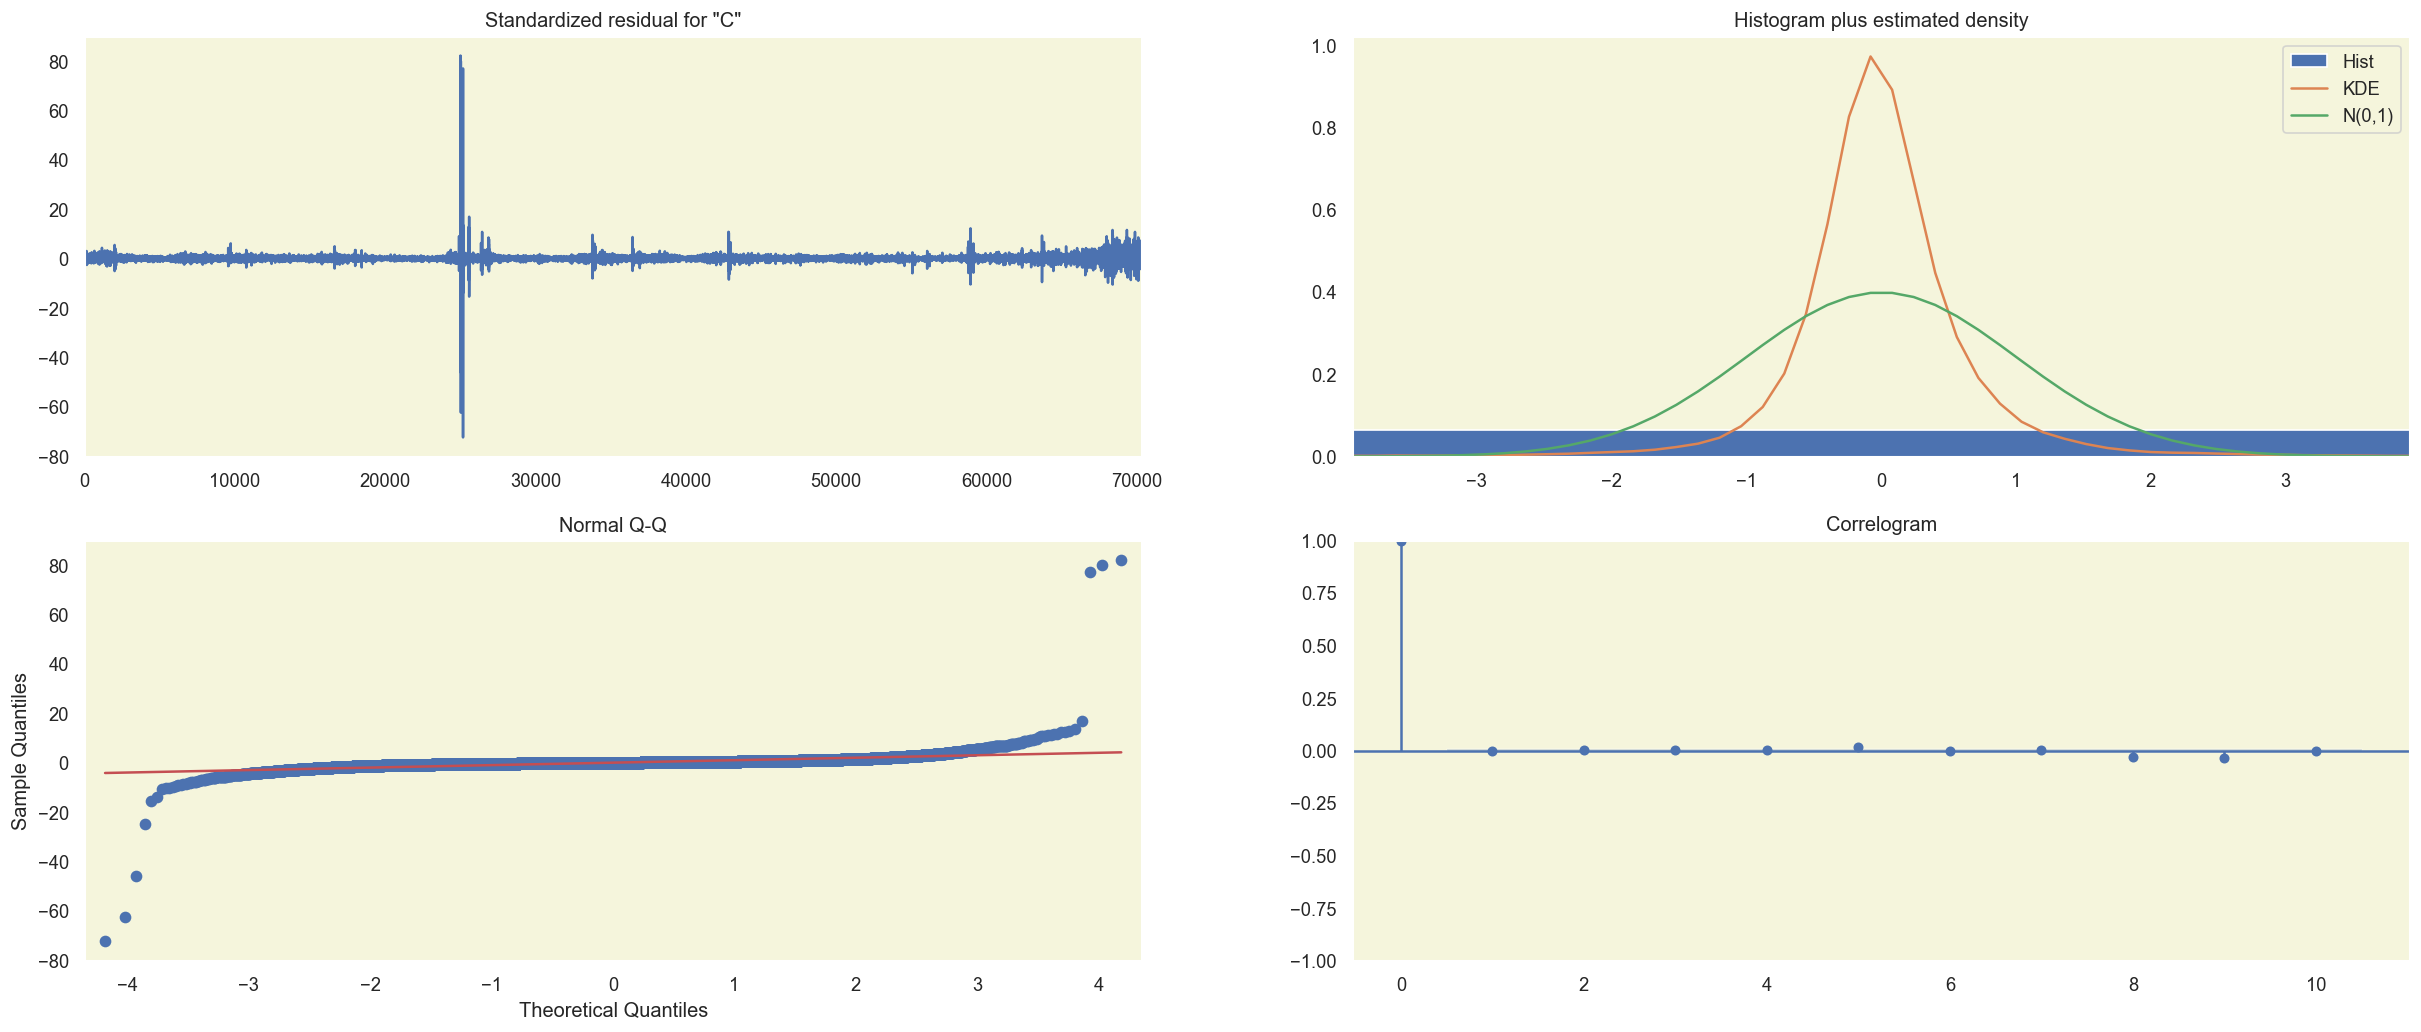

In [93]:
# train test split
train_size = int(len(France_df)*0.8)
train , test = France_df.iloc[:train_size] , France_df.iloc[train_size:]

p = 5  
d = 1
q = 2

model = ARIMA(France_df, order=(p, d, q))
model_fit = model.fit()

# Summary of the model
print(model_fit.summary())

# Plot diagnostic plots
model_fit.plot_diagnostics(figsize=(25,10))
plt.show()

In [94]:
# Predictions
predictions = model_fit.forecast(steps=len(test))
mse = mean_squared_error(test, predictions)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 14578.474074856978


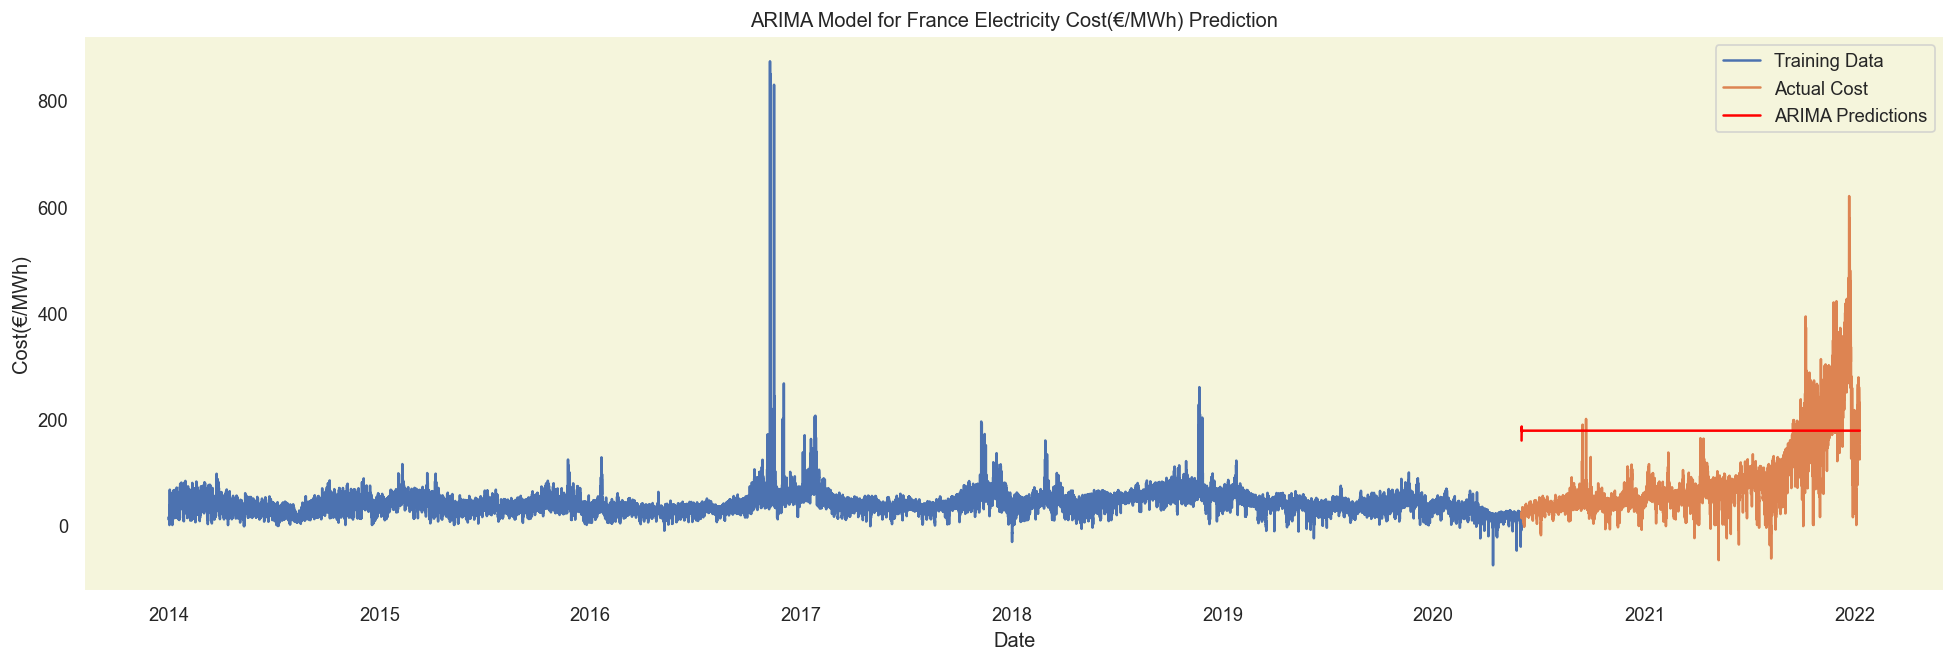

In [97]:
# Plot the results
plt.figure(figsize=(20, 6))
plt.plot(train, label='Training Data')
plt.plot(test, label='Actual Cost')
plt.plot(test.index, predictions, label='ARIMA Predictions', color='red')
plt.title('ARIMA Model for France Electricity Cost(€/MWh) Prediction')
plt.xlabel('Date')
plt.ylabel('Cost(€/MWh)')
plt.legend()
plt.show()

# SARIMA Model

### SARIMA for Time Series Forecasting
In the realm of time series analysis, predicting future values from past observations is a constant pursuit. SARIMA (Seasonal Autoregressive Integrated Moving Average) emerges as a powerful tool for this task, particularly for data exhibiting seasonality.

### What is SARIMA?
SARIMA is a statistical model that builds upon the ARIMA (Autoregressive Integrated Moving Average) model by incorporating a seasonal component. It leverages past observations (AR), potential differencing to achieve stationarity (I), and past errors (MA) to make predictions, all while accounting for seasonal patterns (seasonal AR, seasonal differencing, and seasonal MA).

### Key Components of SARIMA:
- Non-seasonal AR (p): This captures the influence of past values (up to p lags) on the current value.
- Differencing (d): Differencing is applied if the data exhibits non-stationarity (trend or increasing/decreasing variance). It removes the trend by subtracting the previous value from the current value.
- Non-seasonal MA (q): This considers the impact of past forecast errors (up to q lags) on the current value.
- Seasonal AR (P): Similar to non-seasonal AR, this captures the influence of past seasonal values (e.g., past year's values for monthly data).
- Seasonal Differencing (D): Similar to differencing, this removes seasonal trends if present.
- Seasonal MA (Q): This considers the impact of past seasonal forecast errors on the current value.
- Seasonality (s): This specifies the number of periods in a single season (e.g., s=12 for monthly data).

### $$SARIMA(p, d, q)(P, D, Q)m$$

### Example: Predicting Electricity Prices
Imagine you're tasked with forecasting electricity prices. Electricity usage often exhibits seasonality, with higher demand during peak summer and winter months. A SARIMA model can be a good fit for this scenario.

Here's a simplified example:

You might choose a model with p=2 (considering the influence of the past two days' prices), d=1 (differencing to remove trends), q=1 (accounting for the previous day's forecast error). Additionally, you might include seasonal components like P=1 (considering the influence of the same day last month's price) and s=12 (accounting for monthly seasonality). By analyzing past electricity prices and fitting the SARIMA model with these parameters, you can generate forecasts for future electricity prices.

### Benefits of SARIMA:
- Effective for Seasonal Data: It excels at capturing and predicting trends in data with seasonal patterns.
- Relatively Easy to Implement: Compared to more complex models, SARIMA offers a good balance of accuracy and interpretability.
- Provides Model Diagnostics: The model can be assessed to identify potential shortcomings and refine its parameters for better results.

### Limitations of SARIMA:
- Requires Stationary Data: The model assumes stationarity in the data. If trends or non-constant variance exist, differencing might be needed.
- Parameter Tuning Can Be Challenging: Choosing the optimal hyperparameters (p, d, q, P, D, Q, s) can be an iterative process. Techniques like ACF and PACF analysis can help guide this process.
- Overall, SARIMA is a versatile tool for time series forecasting, particularly when dealing with seasonal data. Its interpretable nature and effectiveness make it a valuable weapon in the arsenal of data scientists and analysts.

In [99]:
# Splitting data (assuming France_df is your data)
train_size = int(len(France_df) * 0.8)
train, test = France_df.iloc[:train_size], France_df.iloc[train_size:]

# Define hyperparameters in a dictionary (easier to modify)
model_params = {
    'order': (5, 1, 2),  # Non-seasonal parameters (p, d, q)
    'seasonal_order': (1, 1, 1, 12),  # Seasonal parameters (P, D, Q, s)
}

# Build and fit the model in one step
model = SARIMAX(train, **model_params).fit()

# Make predictions and calculate MSE
predictions = model.forecast(steps=len(test))
mse = mean_squared_error(test, predictions)
print(model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                          Cost(€/MWh)   No. Observations:                56256
Model:             SARIMAX(5, 1, 2)x(1, 1, [1], 12)   Log Likelihood             -192646.646
Date:                              Sat, 02 Nov 2024   AIC                         385313.292
Time:                                      13:09:49   BIC                         385402.667
Sample:                                           0   HQIC                        385341.136
                                            - 56256                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3531      0.000  -1077.303      0.000      -0.354      -0.352
ar.L2          0.70

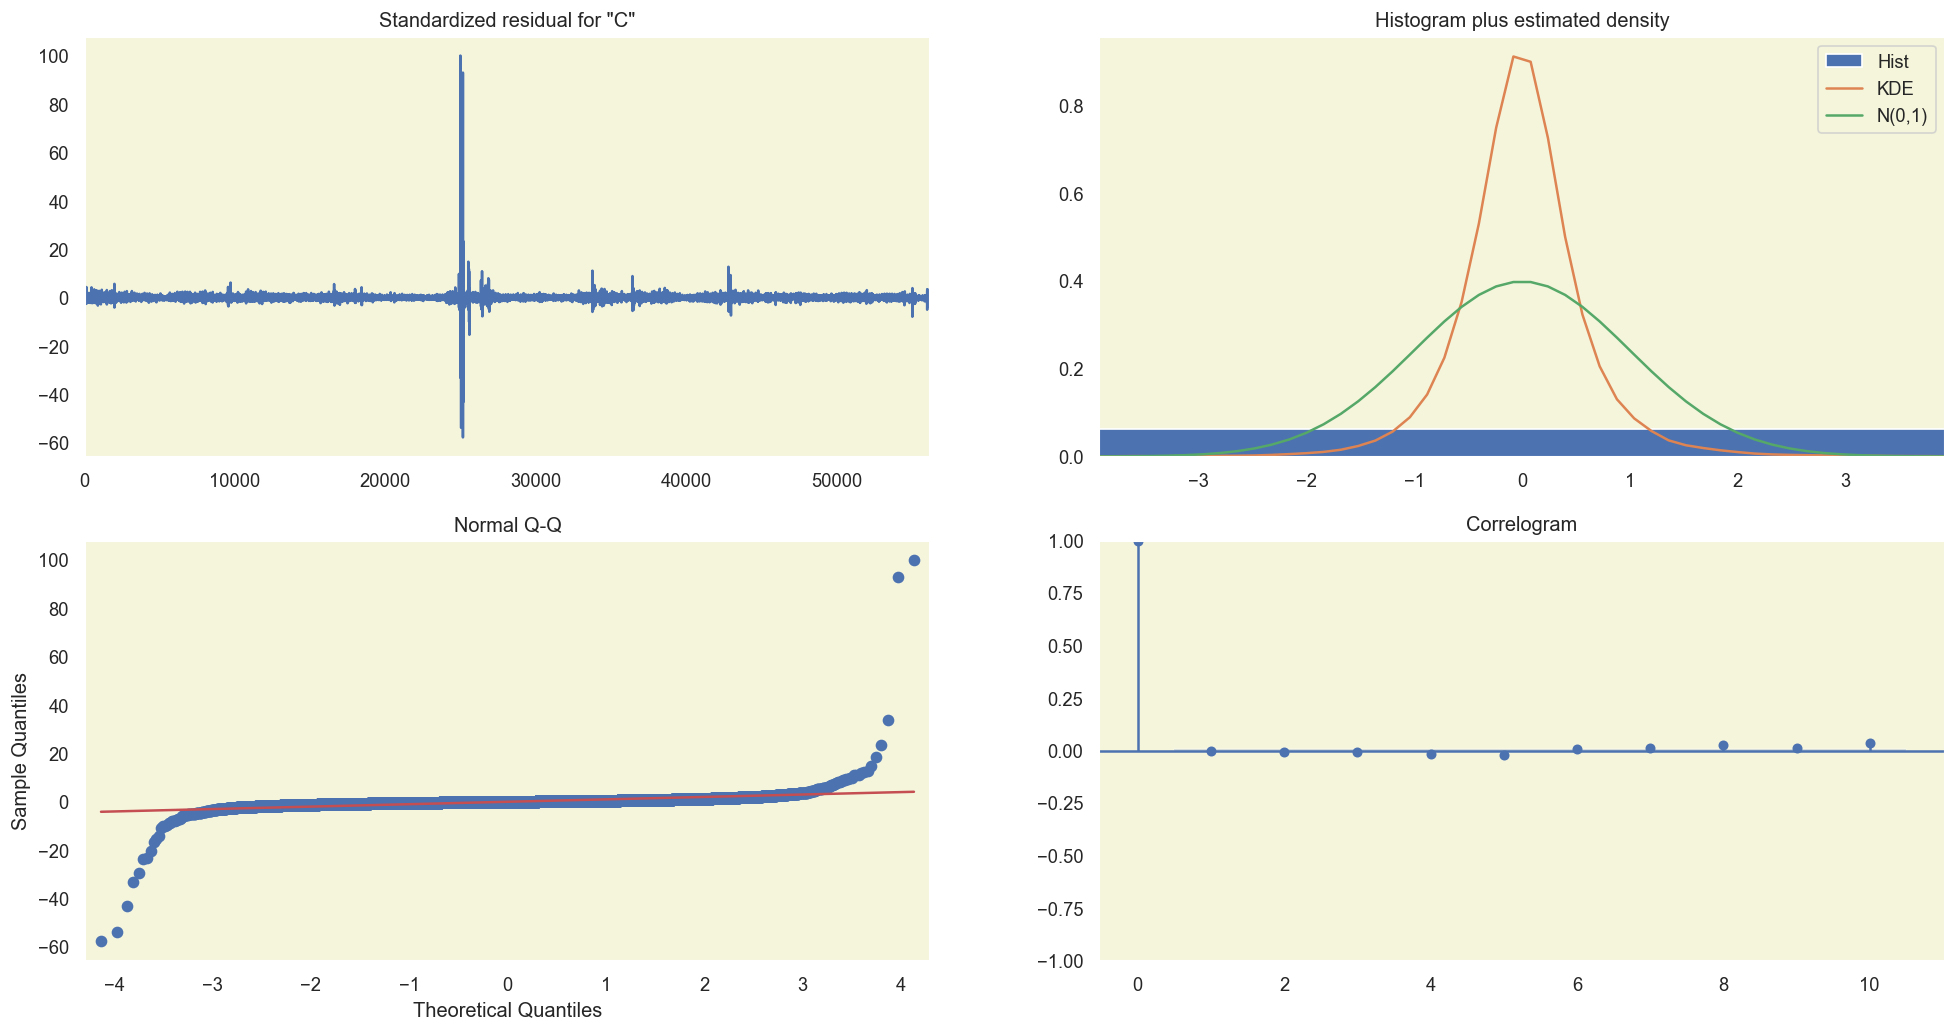

In [100]:
model.plot_diagnostics(figsize=(20, 10))
plt.show()

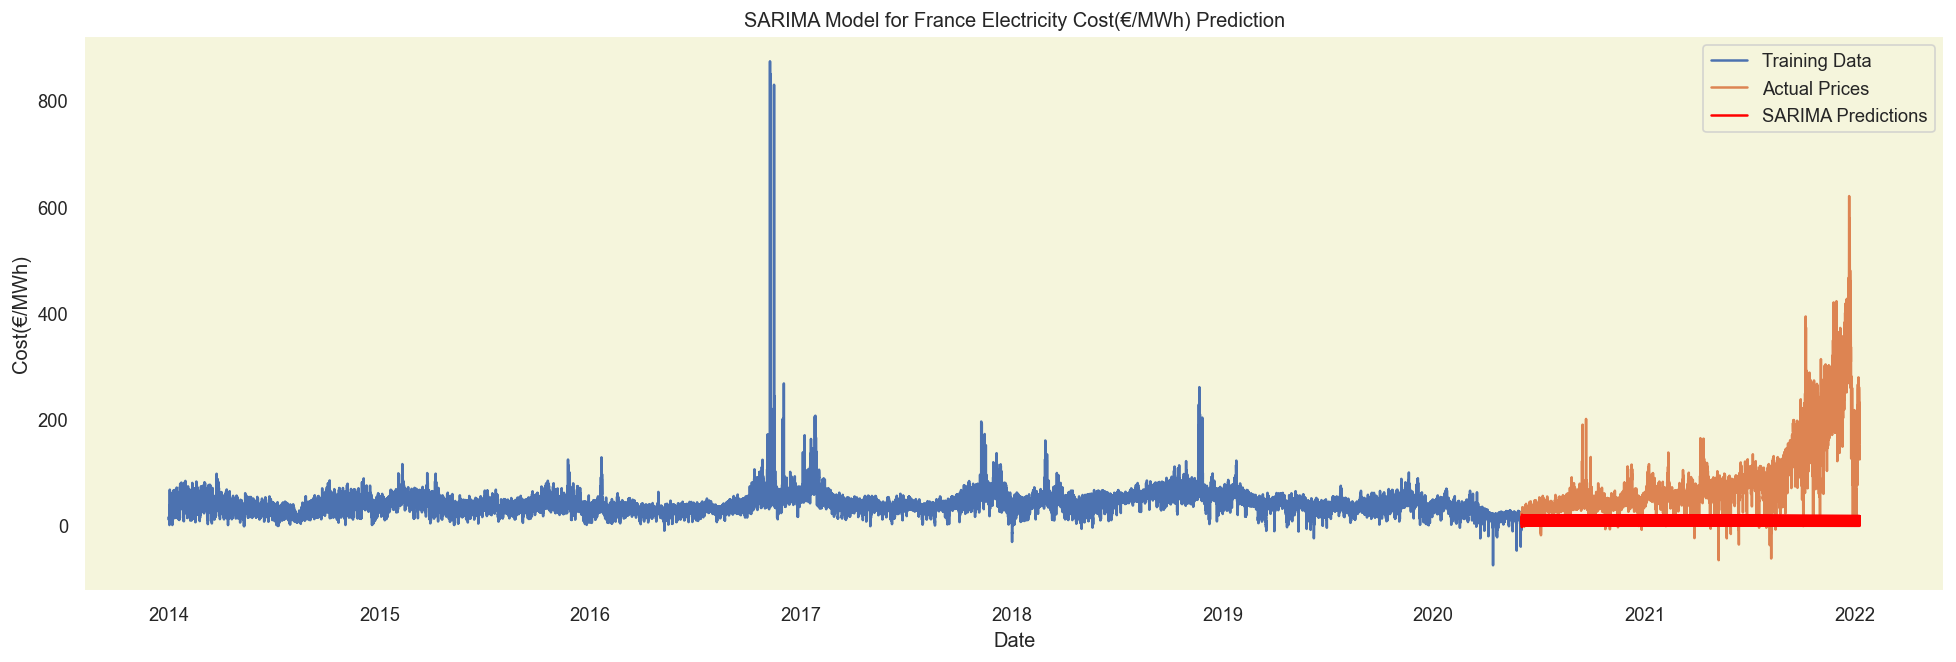

In [101]:
# Plot results (adjust figure size as needed)
plt.figure(figsize=(20, 6))
plt.plot(train, label='Training Data')
plt.plot(test, label='Actual Prices')
plt.plot(test.index, predictions, label='SARIMA Predictions', color='red')
plt.title('SARIMA Model for France Electricity Cost(€/MWh) Prediction')
plt.xlabel('Date')
plt.ylabel('Cost(€/MWh)')
plt.legend()
plt.show()